### generating then ranking audio
- load the CNN model (or some other ranker) from feature_extraction 
- genereate parameters and its corresponding audio "randomly"
- rank the parameters using the ranker
- save the parameters that made the sound along with the rankings to some dataframe

In [30]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

from pathlib import Path

# generation imports
from pippi.soundbuffer import SoundBuffer
from pippi import dsp,fx
import param_generation as pg
import _pickle as pickle
from IPython.display import Audio
from feature_extraction.mir_utils import *
###
import torch.utils.data as utils
import torchvision.transforms as transforms
from PIL import Image
###
import scipy.stats as ss
import common_vars as comv
import imp
import librosa
import librosa.display
import sys
import csv
sys.path.append("..")

import helpers
imp.reload(helpers)
imp.reload(comv)
imp.reload(pg)
from feature_extraction import pytorch_models as tm
imp.reload(tm)
from helpers import *

from common_vars import SR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
save_path="./generated_sample_pack/"
device = "cpu"
stack_size=3
BATCH_SIZE=1
NUM_BINS=100

classes=comv.classes
classes_ranked=comv.classes_ranked
cDict={v:i for i,v in enumerate(classes)}

drum_groups=['tom_low','snare','hihat_closed','rim','synth_noise','clap','kick','hihat_open','tom_mid']


drum_df=pd.DataFrame(columns=["name","fc","cnnlstm","env+freq","consensus","stack_size"])

In [31]:
import feature_extraction.pytorch_models as pm
import imp

imp.reload(pm)

input_dim = 120
seq_dim=100
output_size = 5
hidden_dim = 1000
n_layers = 1

    
#########DVN#########
#env model stuff
env_model_dvn = tm.env_Model(D_in=10,H1=10,H2=5,H3=10,H4=2,H5=10,device=device)
state='./feature_extraction/models/fc/env_dvn_95_35.pt'
env_model_dvn.load_state_dict(torch.load(state))
env_trans=tm.envTrans()
env_model_dvn.to(device)


# pitch model stuff
fc_spec_model_dvn=tm.getFCSpecModel(D_in=20*20,H1=20,H2=10,H3=4,D_out=2)
state='./feature_extraction/models/fc/spec_fc_dvn_96.pt'
fc_spec_model_dvn.load_state_dict(torch.load(state))
fc_spec_trans_dvn=tm.specTrans(20)
fc_spec_model_dvn.to(device)

#cnn lstm
cnn_model_dvn=pm.CNNLSTM_dvn()
state='./feature_extraction/models/cnn/clst_dvn_96_279.pt'
cnn_model_dvn.load_state_dict(torch.load(state))
cnn_model_dvn.to(device)
cnn_model_dvn.to(device)
#########DVD#########
#fc dvd
dvd_fc=pm.getFCSpecModel(D_in=20*20,H1=100,H2=50,H3=100,D_out=len(drum_groups))
state='./feature_extraction/models/fc/spec_fc_dvd_81.pt'
dvd_fc.load_state_dict(torch.load(state))
dvd_fc.to(device)

#cnn_dvd
dvd_cnn=pm.CNNLSTM_dvd(len_out=len(drum_groups))
state='./feature_extraction/models/cnn/clst_dvd_90_170.pt'
dvd_cnn.load_state_dict(torch.load(state))
dvd_cnn.to(device)

#freq+env model
freq_env_model_dvd = tm.env_freq_Model(D_in=60,H1=30,H2=10,H3=10,D_out=len(drum_groups))
state='./feature_extraction/models/fc/freq_env_dvd_86_351.pt'
freq_env_model_dvd.load_state_dict(torch.load(state))
freq_env_trans=tm.freq_and_env_Trans(feat_mels=50,env_mels=1)
freq_env_model_dvd.to(device)



from IPython.display import Audio
import librosa.display

for g in drum_groups:
    Path(save_path+"/"+g).mkdir(parents=True, exist_ok=True)


env score 0.7615298628807068
fc_spec 0.0005134455859661102
o_cnn_spec 0.0001600710384082049
fc category synth_noise 
cnn category synth_noise 
env+freq synth_noise
total consensus synth_noise
it took 91 iteration, stack size 2


<Figure size 864x216 with 0 Axes>

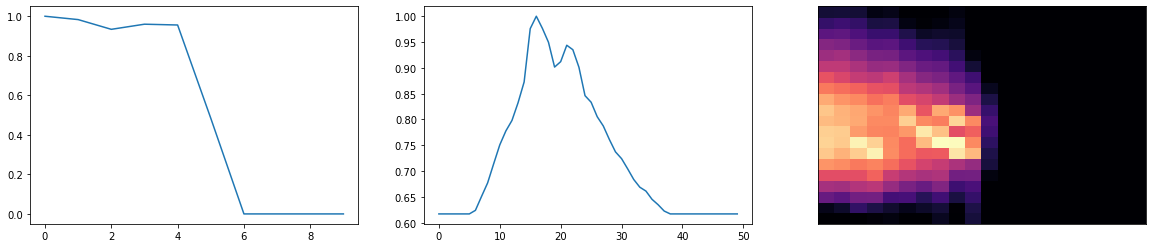

In [34]:

def findDrum(stack_size=1,iteration=0):
    out,params= stackMaker(stack_size)
    a= memToAud(out)
    try:
        a=librosa.util.normalize(a)
    except:
        pass
    transform_input= {"signal":torch.tensor(a,dtype=torch.float),"label":torch.tensor(0)}
    env_feats=env_trans.call(transform_input)["feats"].to(device)
    freq_feats=freq_env_trans.call(transform_input)["feats"].to(device)
    pitch_feats=fc_spec_trans_dvn.call(transform_input)["feats"].to(device)
    spec_flat=torch.flatten(pitch_feats, start_dim=1)

    (params,a,
    outputEnvFreq,
    outputCNNDVD,
    outputFCDVD,
    outputE,
    outputSPECFC,
    outputCNN,
    env_feats,
    freq_feats,pitch_feats)=(params,a,
            freq_env_model_dvd(freq_feats),
            dvd_cnn(pitch_feats.reshape(-1,1,20,20)),
            dvd_fc(spec_flat),
            env_model_dvn(env_feats),
            fc_spec_model_dvn(spec_flat),
            cnn_model_dvn(pitch_feats.reshape(-1,1,20,20)),
            env_feats,
            freq_feats,
            pitch_feats)
    
    o_e,o_fc_spec,o_cnn_spec=outputE[0].item(), outputSPECFC[0][0].item() ,outputCNN[0][0].item()
    tote=outputE[0].item()+outputSPECFC[0][0].item()

    gfc=drum_groups[torch.argmax(outputFCDVD).item()]
    gcnn=drum_groups[torch.argmax(outputCNNDVD).item()]
    genvfreq=drum_groups[torch.argmax(outputEnvFreq).item()]
    cat_consensus=drum_groups[torch.argmax(outputFCDVD+outputCNNDVD+outputEnvFreq)]
    
    spec_score=(o_fc_spec+o_cnn_spec)/2
    if (o_e>=0.5 and o_fc_spec>=0.) or (o_e>0.5 and o_cnn_spec>0.7):
        print("env score",o_e)
        print("fc_spec",o_fc_spec)
        print("o_cnn_spec",o_cnn_spec)
        print("fc category",gfc,"\ncnn category",gcnn,"\nenv+freq",genvfreq)
        print("total consensus",cat_consensus)
        
#         drum_name=("%d-%s.wav"%(stack_size,string_generator()))
#         out.write("./generated_sample_pack/survey/%s"%(drum_name,))
        
#         row=[drum_name,spec_score,gfc,gcnn,genvfreq,cat_consensus,stack_size,iteration]
#         print(row)

#         with open(save_path+"/model_predictions.csv", "a", newline='') as fp:
#             wr = csv.writer(fp, dialect='excel')
#             wr.writerow(row)
            
        return(a,env_feats,freq_feats,pitch_feats,stack_size,"found")
    return (a,env_feats,freq_feats,pitch_feats,stack_size,"not_found")

i=0
j=0
while i<10000000:
    i=i+1
    j=j+1
    stack_size=np.random.choice([2])
    (a,env_feats,freq_feats,pitch_feats,stack_size,results)=findDrum(stack_size,iteration=i)
    if results!="not_found":
        print("it took %d iteration, stack size %d"%(j,stack_size))
        j=0
        break

fig = plt.figure(figsize=(12,3))
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(1, 3,1)

plt.plot(env_feats)
ax = plt.subplot(1, 3,2)
plt.plot(freq_feats[0:50])
ax=plt.subplot(1,3,3)
ft=pitch_feats
ft=ft.numpy()
librosa.display.specshow(ft[0])
Audio(a,rate=sr, autoplay=True)